# Investigating Effect of Entanglement on Virtualization's Fidelity

In this notebook, we test out the hypothesis that the performance of a virtualized circuit deteriorate with the increasing amount of entanglement between the two fragments of the cut two-qubit gate.

The measure of entanglement in this experiment is "entanglement of formation", which is a measure of the entanglement between two qubits. Thus, our experiments will be limited to two-qubit circuits only.

The following parameters will be tried out for this experiment:
- Exact virtualization of the CNOT gate.
- Approximate virtualization of the CNOT gate.

For the setup of the experiment, we build a Bell-state preparation circuit where a qubit in superposition is entangled with another using a CNOT. The superposition is parameterized, and is controlled by an RY gate followed by an RX gate.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product
from pprint import pprint

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, entanglement_of_formation

import vqc
from vqc.benchmarking.fidelity import fidelity
from vqc.cutting import KernighanLinBisection
from vqc.executor import Simulator

Let's first perform a 2D-sweep along different values of RY and RX rotation to see how the entanglement changes.

In [3]:
resolution = 50
rx_vals = np.linspace(0, np.pi, resolution)
ry_vals = np.linspace(0, np.pi, resolution)

In [4]:
def circ():
    ry_parameter = Parameter('ry_theta')
    rx_parameter = Parameter('rx_theta')
    qc = QuantumCircuit(2, 2)
    qc.ry(theta=ry_parameter, qubit=0)
    qc.rx(theta=rx_parameter, qubit=0)
    qc.cnot(0, 1)
    qc.measure(qubit=[0, 1], cbit=[0, 1])

    return qc, rx_parameter, ry_parameter

In [5]:
qc, rx_param, ry_param = circ()
print(qc)

     ┌──────────────┐┌──────────────┐     ┌─┐   
q_0: ┤ Ry(ry_theta) ├┤ Rx(rx_theta) ├──■──┤M├───
     └──────────────┘└──────────────┘┌─┴─┐└╥┘┌─┐
q_1: ────────────────────────────────┤ X ├─╫─┤M├
                                     └───┘ ║ └╥┘
c: 2/══════════════════════════════════════╩══╩═
                                           0  1 


In [6]:
grid_results = {}
qc_no_meas = qc.remove_final_measurements(inplace=False)
for rx_angle, ry_angle in product(rx_vals, ry_vals):
    curr_qc = qc_no_meas.bind_parameters({rx_param: rx_angle, ry_param: ry_angle})
    sv = Statevector.from_instruction(curr_qc)

    grid_results[(rx_angle, ry_angle)] = entanglement_of_formation(sv)

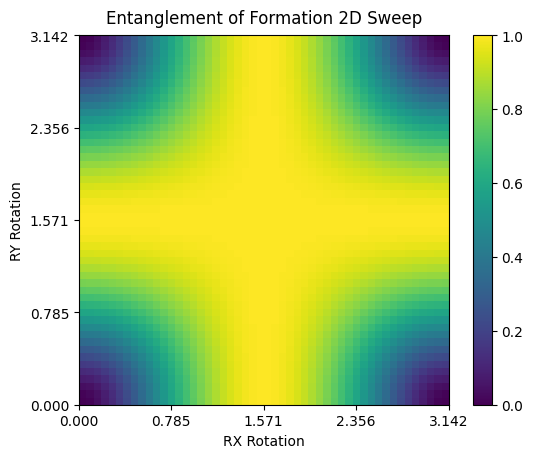

In [7]:
ent = np.array(list(grid_results.values()))

fig, ax = plt.subplots()
ax_ = ax.imshow(
    ent.reshape(resolution, resolution),
    origin="lower",
    vmin=0,
    vmax=1,
    extent=(0, np.pi, 0, np.pi),
)
fig.colorbar(ax_)
ax.set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax.set_yticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])

plt.title("Entanglement of Formation 2D Sweep", y=1.01)
plt.xlabel("RX Rotation")
plt.ylabel("RY Rotation")

plt.show()

It seems that we achieve maximum entanglement within one quadrant, so we can limit the domain of our experiment (i.e. the rotation angles) to $$x,y \in [0, \pi]$$

In [8]:
virt_circuit = vqc.cutting.cut(qc, KernighanLinBisection())
knitter = vqc.Knitter(virt_circuit)
samples = knitter.samples()
pprint(samples)

{'frag0': [<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fef70ac3b80>,
 'frag1': [<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fef709c6d40>,
           <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fef70a4df90>]}


In [11]:
sim = Simulator()
fidelity_results = {}
for rx_angle, ry_angle in tqdm(zip(rx_vals, ry_vals), total=len(rx_vals)):
    results = sim.execute(samples, {rx_param: rx_angle, ry_param: ry_angle})
    prob_distr = knitter.knit(results)
    fidelity_results[(rx_angle, ry_angle)] = fidelity(
        qc.bind_parameters({rx_param: rx_angle, ry_param: ry_angle}),
        prob_distr.counts(10000),
    )

100%|██████████| 50/50 [04:02<00:00,  4.84s/it]


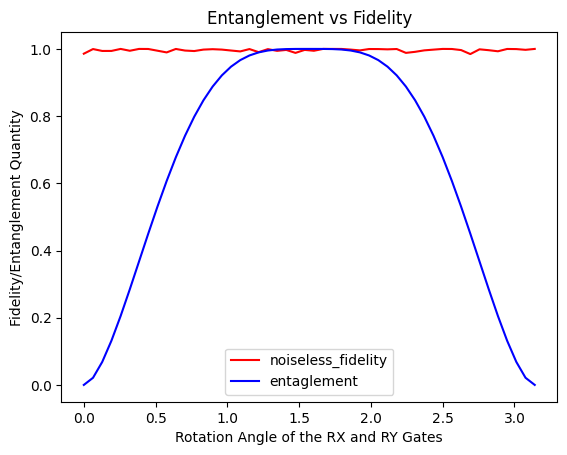

In [20]:
plt.plot(rx_vals, fidelity_results.values(), color='r', label='noiseless_fidelity')
plt.plot(rx_vals, [grid_results[(ang, ang)] for ang in rx_vals], color='b', label='entaglement')

plt.xlabel("Rotation Angle of the RX and RY Gates")
plt.ylabel("Fidelity/Entanglement Quantity")
plt.title("Entanglement vs Fidelity")
  
plt.legend()
# plt.plot(X, z, color='g', label='cos')

In [23]:
np.corrcoef(np.array([list(fidelity_results.values()), [grid_results[(ang, ang)] for ang in rx_vals]]))[0, 1]

0.03654222915383457